<h1> Lapakis Gerasimos - P3170089 - ICAD ASSIGNMENT 3: Greek Parliament Proceedings 1989-2019</h1>

**Note: This file uses relative file paths, so all files must be included in the same directory as this ipynb.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats.stats as stats
import string
import datetime

import spacy
from spacy.lang.el.stop_words import STOP_WORDS

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Softmax, Dense, Embedding, LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

%matplotlib inline
matplotlib.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
proceedings = pd.read_csv('Greek_Parliament_Proceedings_1989_2019.csv', encoding='utf-8', parse_dates=['sitting_date'])

Deleting NaN values.

In [3]:
proceedings = proceedings[proceedings['speech'].notna()]

In [4]:
proceedings = proceedings[proceedings['political_party'].notna()]

We will keep half of the dataset, preoceedings from 2004 to 2019.

In [5]:
proceedings = proceedings[(proceedings['sitting_date'].dt.date >= datetime.date(year=2004,month=1,day=1))]

Speeches Per Party

In [6]:
SpeechesPerParty = proceedings.groupby('political_party').count().sort_values(by='speech', ascending=False)
SpeechesPerParty[['speech']]

,speech
political_party,
νεα δημοκρατια,226352
πανελληνιο σοσιαλιστικο κινημα,131373
συνασπισμος ριζοσπαστικης αριστερας,126572
κομμουνιστικο κομμα ελλαδας,59024
βουλη,27821
ανεξαρτητοι (εκτος κομματος),26051
λαικος ορθοδοξος συναγερμος,23639
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα),22991
λαικος συνδεσος - χρυση αυγη,14172


In [7]:
proceedings

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
492726,τζεκης κωνσταντινου αγγελος,2004-01-07,period 10 presided parliamentary republic,session 4,sitting 55,κομμουνιστικο κομμα ελλαδας,NaN,"Σε δύο ενότητες πότε, κύριε Υπουργέ; Σήμερα;"
492727,σγουριδης σγουρη παναγιωτης,2004-01-07,period 10 presided parliamentary republic,session 4,sitting 55,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Τη μια ενότητα σήμερα και τη δεύτερη αύριο μα...
492728,τζεκης κωνσταντινου αγγελος,2004-01-07,period 10 presided parliamentary republic,session 4,sitting 55,κομμουνιστικο κομμα ελλαδας,NaN,"Πάρτε υπόψη σας, κύριε Πρόεδρε, ότι είναι και..."
492729,σγουριδης σγουρη παναγιωτης,2004-01-07,period 10 presided parliamentary republic,session 4,sitting 55,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Ορίστε, κύριε Βλαχόπουλε, έχετε το λόγο."
492730,βλαχοπουλος δημητριου ηλιας,2004-01-07,period 10 presided parliamentary republic,session 4,sitting 55,πανελληνιο σοσιαλιστικο κινημα,NaN,Κύριε Πρόεδρε και εγώ συμφωνώ με την πρότασή ...
...,...,...,...,...,...,...,...,...
1194402,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ..."
1194403,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο."
1194404,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ..."
1194405,NaN,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."


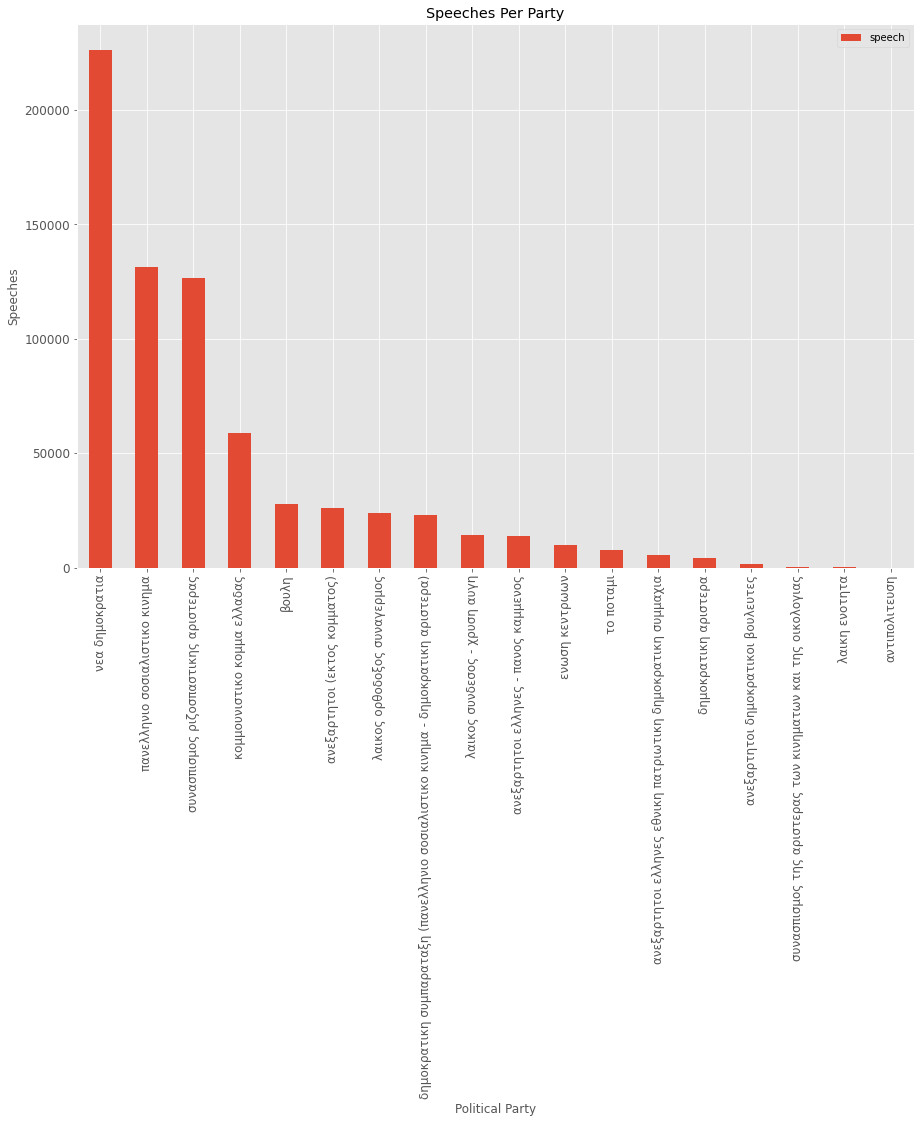

In [8]:
graph = SpeechesPerParty['speech'].plot(kind='bar', title ='Speeches Per Party', figsize=(15, 10), legend=True, fontsize=12)
graph.set_xlabel('Political Party', fontsize=12)
graph.set_ylabel('Speeches', fontsize=12)
plt.show()

Speakers Per Party

In [26]:
SpeakersPerParty = proceedings.groupby('political_party').count().sort_values(by='speaker_info', ascending=False)
SpeakersPerParty[['speaker_info']]

,speaker_info
political_party,
νεα δημοκρατια,156555
συνασπισμος ριζοσπαστικης αριστερας,68837
πανελληνιο σοσιαλιστικο κινημα,58794
βουλη,27821
κομμουνιστικο κομμα ελλαδας,18832
ανεξαρτητοι ελληνες - πανος καμμενος,8855
λαικος ορθοδοξος συναγερμος,8706
ανεξαρτητοι (εκτος κομματος),8241
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα),8055


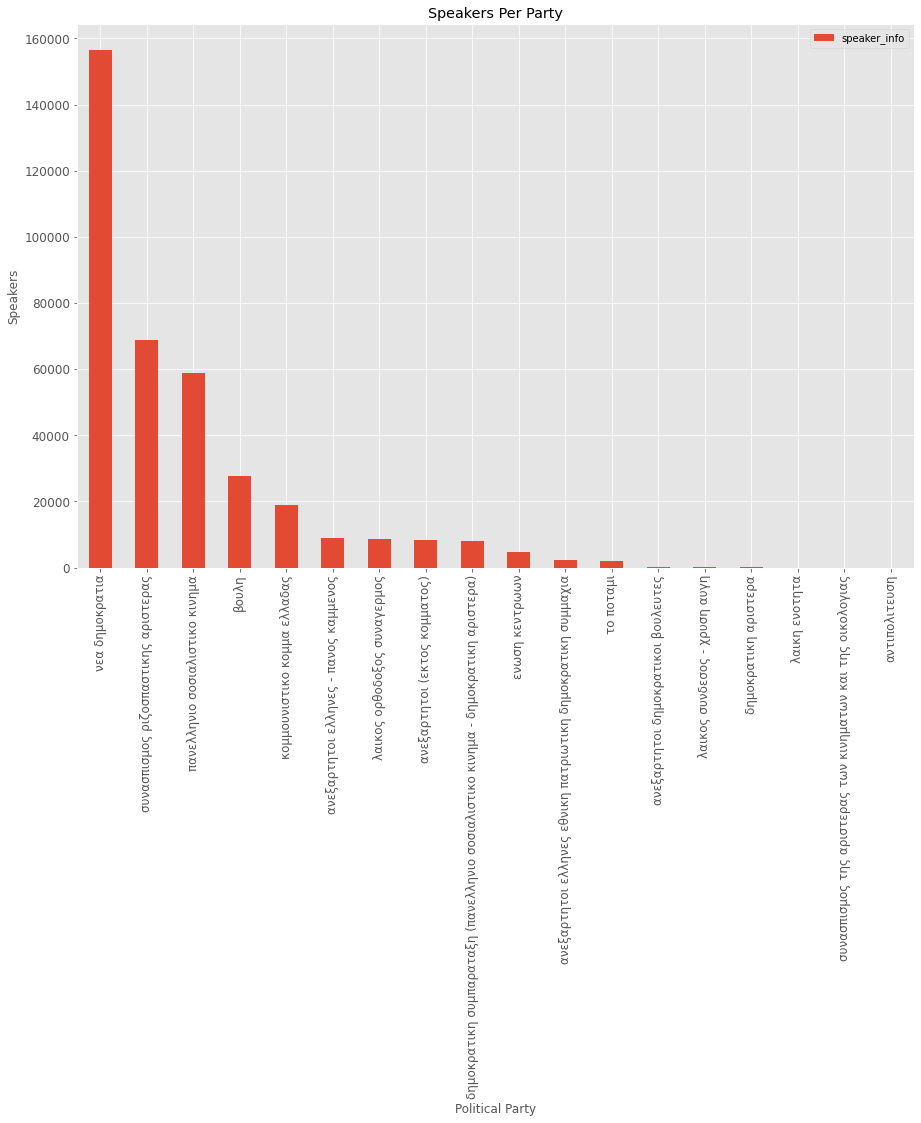

In [27]:
graph = SpeakersPerParty['speaker_info'].plot(kind='bar', title ='Speakers Per Party', figsize=(15, 10), legend=True, fontsize=12)
graph.set_xlabel('Political Party', fontsize=12)
graph.set_ylabel('Speakers', fontsize=12)
plt.show()

Speeches Over Time

In [28]:
SpeechesOverTime = proceedings.set_index(pd.DatetimeIndex(proceedings['sitting_date']))
SpeechesOverTime = SpeechesOverTime.groupby(pd.Grouper(freq='Y')).count()
SpeechesOverTime[['speech']]

,speech
sitting_date,
2004-12-31,26822
2005-12-31,51884
2006-12-31,39535
2007-12-31,37519
2008-12-31,52873
2009-12-31,31020
2010-12-31,45864
2011-12-31,54758
2012-12-31,41307


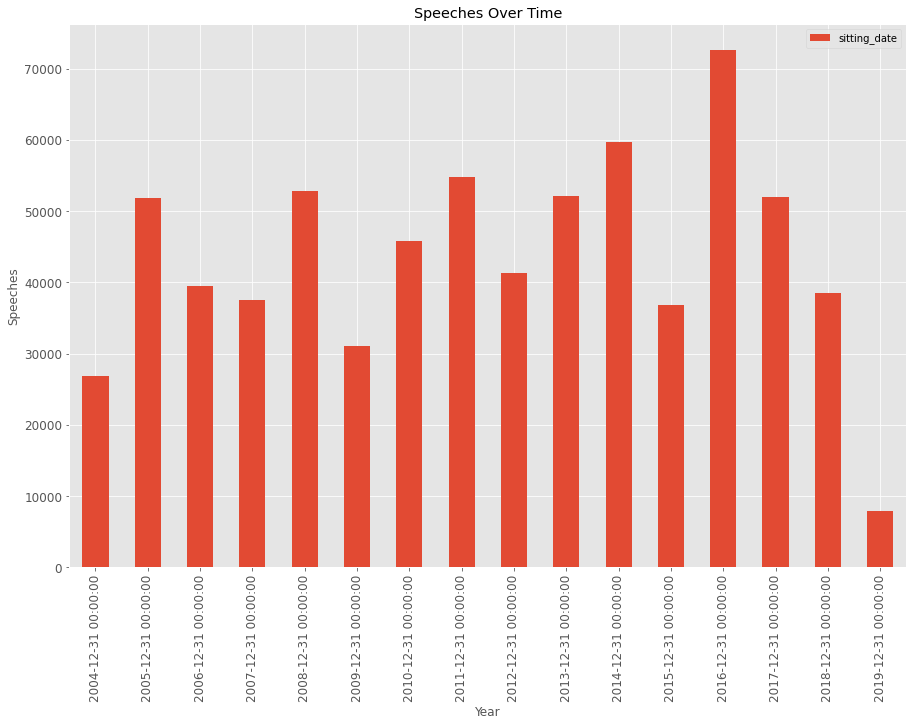

In [29]:
graph = SpeechesOverTime['sitting_date'].plot(kind='bar', title ='Speeches Over Time', figsize=(15, 10), legend=True, fontsize=12)
graph.set_xlabel('Year', fontsize=12)
graph.set_ylabel('Speeches', fontsize=12)
plt.show()

Speeches Per Party And Time

In [174]:
SpeechesPerPartyAndTime = proceedings.set_index(pd.DatetimeIndex(proceedings['sitting_date']))
SpeechesPerPartyAndTime

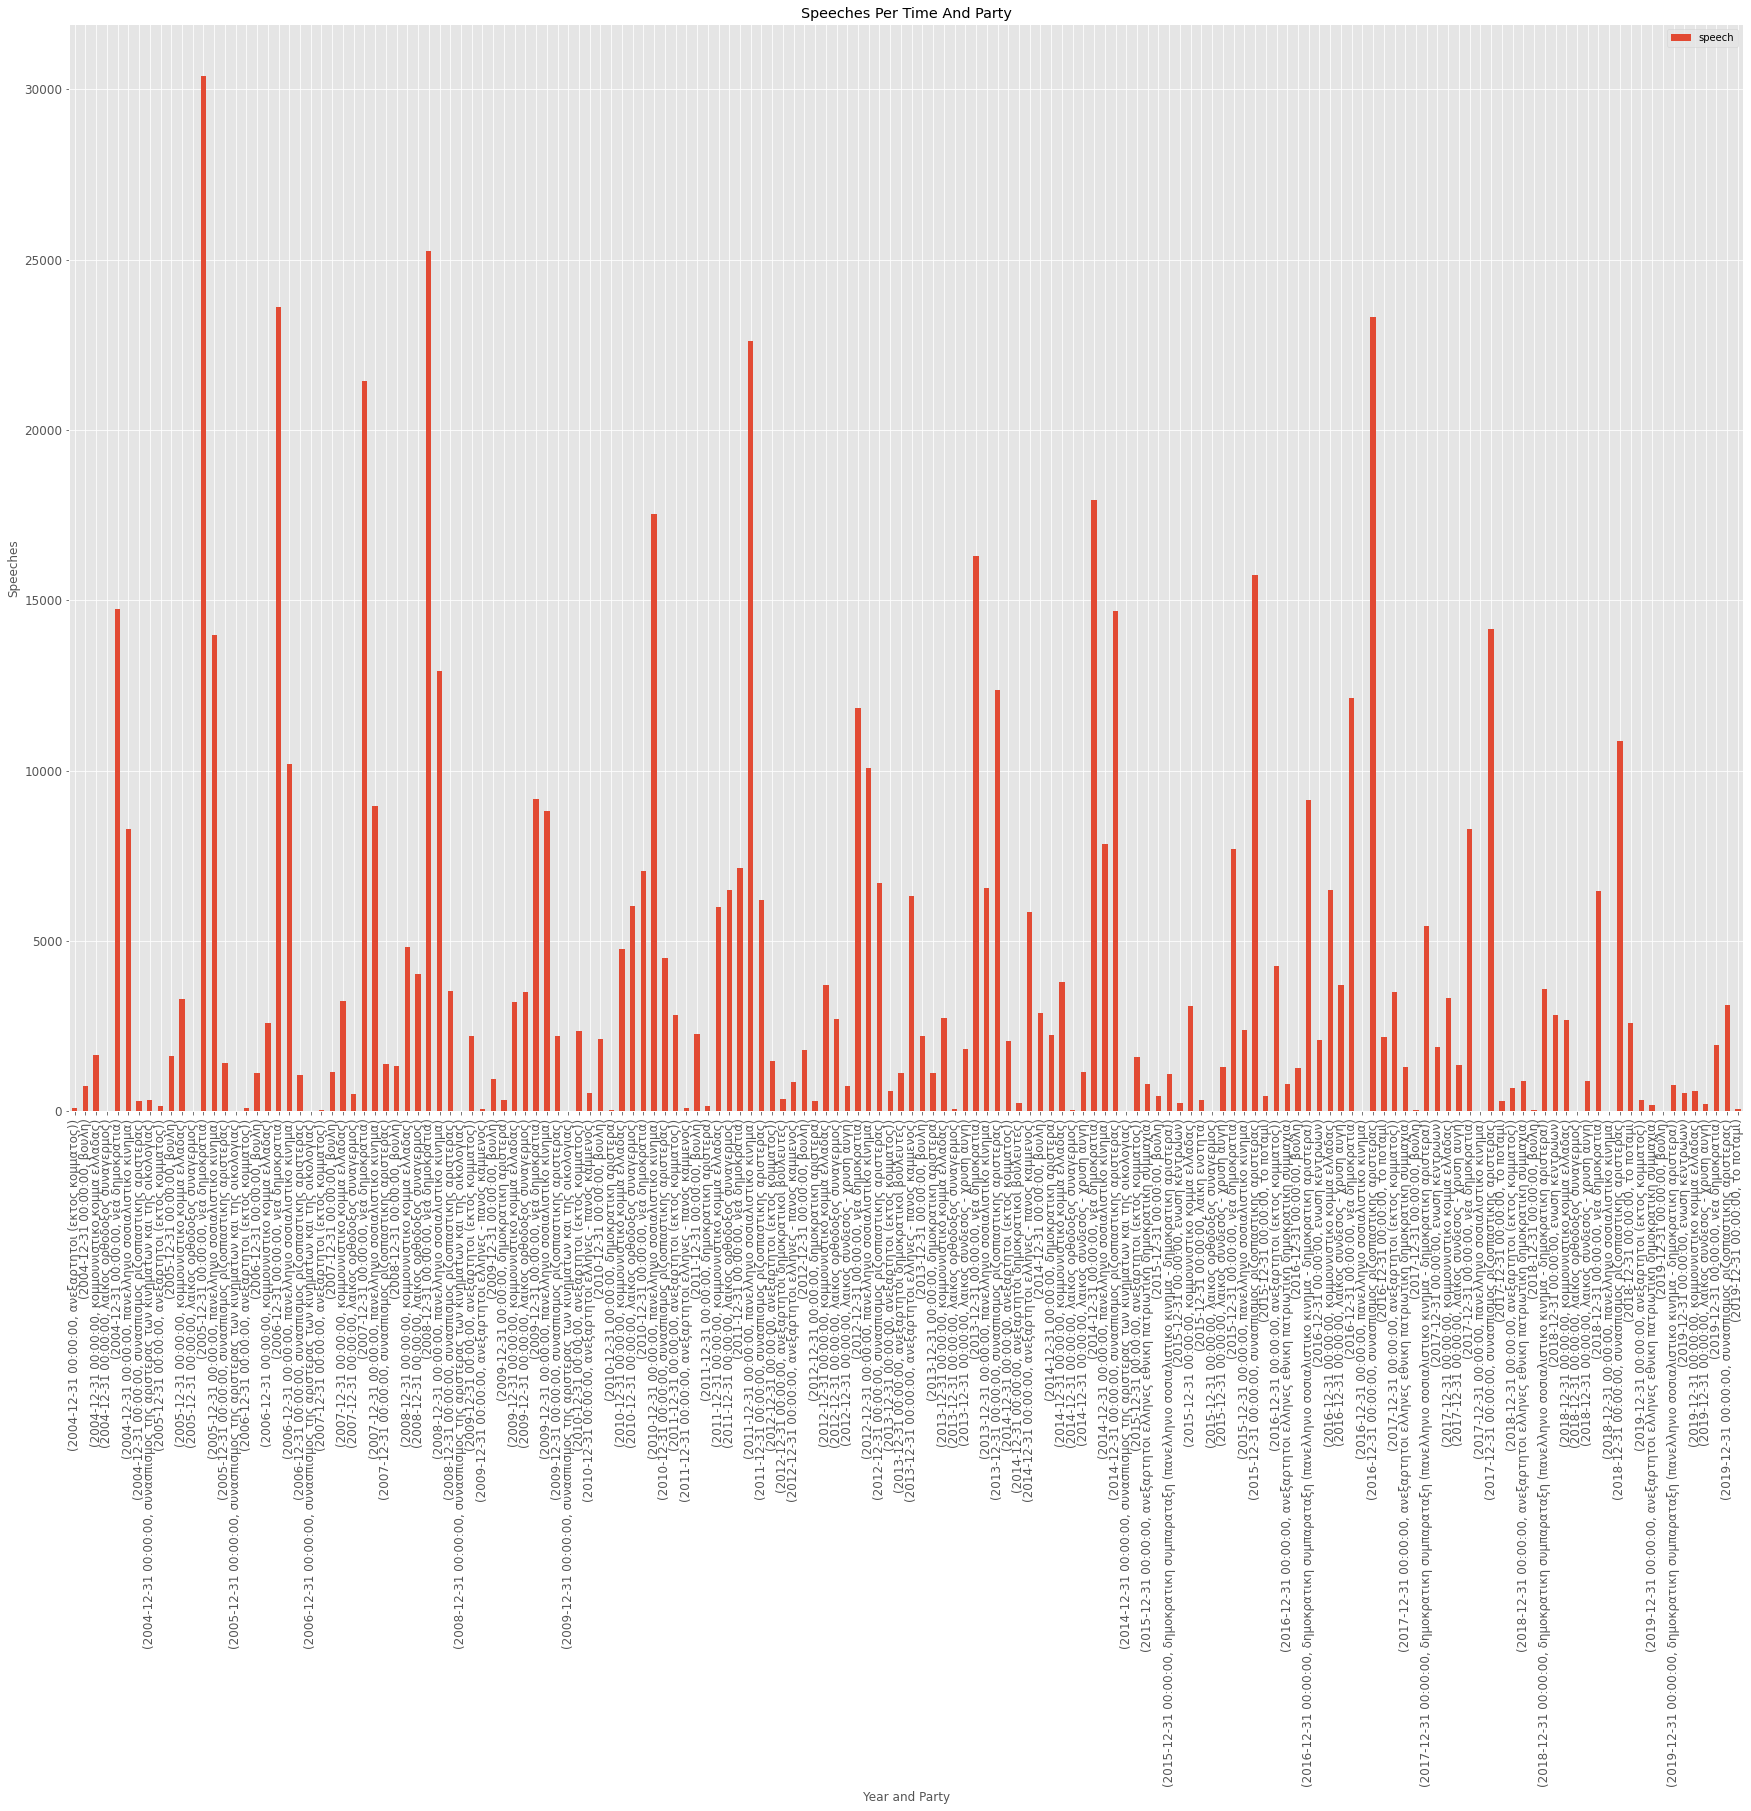

In [176]:
graph = SpeechesPerPartyAndTime.groupby([pd.Grouper(freq='Y'),'political_party'])['speech'].count().plot(kind='bar', title ='Speeches Per Time And Party', figsize=(30, 20), legend=True, fontsize=12)
graph.set_xlabel('Year and Party', fontsize=12)
graph.set_ylabel('Speeches', fontsize=12)
plt.show()

Shuffling the data and setting random state to 42.

In [10]:
proceedings = proceedings.sample(frac=1,random_state=42)

In [11]:
nlp = spacy.load('el_core_news_lg')

<h1>Cleaning the data</h1>

Keeping the greek stop word list of spacy

In [12]:
stopwords = list(STOP_WORDS)

Keeping the punctuation list of string

In [13]:
punct = string.punctuation

Our speech optimizer.  
We are using spacy to tokenize each speech.  
We search if its lemma is in stopwords, so we can exclude this word.  
We do the same for punctuation and also search in list l, which sees if a token is a number(NUM), a symbol(SYM), a punctuation(PUNCT) or an unknown symbol(X).  
Then we put the lemma of each word  into a string, convert it to lowercase and strip it.  

In [14]:
def speech_optimizer(sentence):
    doc = nlp(sentence)
    l = ['NUM', 'SYM', 'PUNCT', 'X']
    s=''
    for token in doc:
        if token.lemma_ not in stopwords and token.lemma_ not in punct and token.lemma_ not in l:
            temp = token.lemma_.lower().strip()
            s=s+' '+temp
    s = s.strip()
    return s

To make tokenization faster for later, we create a new column, cleaned_speech, and apply our fucntion.  
Of course, it takes about 6 hours but makes tfidf Tokenizer run a lot faster.

In [15]:
proceedings['cleaned_speech'] = proceedings['speech'].apply(lambda x: speech_optimizer(x))

We delete the NaN values that may have been produced.

In [16]:
proceedings = proceedings[proceedings['cleaned_speech'].notna()]

<h1>Scikit implementation (2 Non Neural Network Methods)</h1>

Removing αντιπολιτευση as the warning: The least populated class in y has only 1 members, which is less than n_splits=5 will occur

In [3]:
proceedings = proceedings[~proceedings['political_party'].isin(['αντιπολιτευση'])]

In [4]:
proceedings = proceedings[['political_party','cleaned_speech']]

In [4]:
proceedings = proceedings[proceedings['cleaned_speech'].notna()]
proceedings = proceedings[proceedings['political_party'].notna()]

Splitting our data into test and train, with random state = 42

In [5]:
X = proceedings['cleaned_speech']
y = proceedings['political_party']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape

((497657,), (165886,))

<h1> Dummy Classifier </h1>

We test the dummy classifier with most frequent strategy, to see how a random classifier performs with our dataset.

In [17]:
clf = DummyClassifier(strategy='most_frequent')

In [18]:
clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [19]:
y_pred = clf.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred,zero_division=1))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       1.00      0.00      0.00      5466
                                             ανεξαρτητοι δημοκρατικοι βουλευτες       1.00      0.00      0.00       433
                                           ανεξαρτητοι ελληνες - πανος καμμενος       1.00      0.00      0.00      3551
                     ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια       1.00      0.00      0.00       976
                                                                          βουλη       1.00      0.00      0.00      5057
                                                           δημοκρατικη αριστερα       1.00      0.00      0.00      1045
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       1.00      0.00      0.00      5096
                               

Following this [cheat-sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) form scikit's official website I decided to test SGD, LinearSVC and MultinomialNB.

<h1>Grid Search with MultinomialNB (all parties)</h1>

For MultinomialNB I decided to run the Grid Search with the following parameters:  
alpha is a smoothing parameter.  
For the tfidf vectorizer:  
max df ignores terms that appear in more than X% of speeches.  
ngram range takes unigrams(1,2) and bigrams(2,2).  

In [45]:
tfidf = TfidfVectorizer()

In [46]:
parameters = {
    'tfidf__max_df': (0.50, 0.80),
    'tfidf__ngram_range': [(1, 2), (2, 2)],
    'clf__alpha': (0.001, 0.01, 0.1, 0, 1, 1.5)
}

In [47]:
clf = Pipeline([('tfidf',tfidf), ('clf', MultinomialNB())])

In [17]:
GridMNB = GridSearchCV(clf, parameters, n_jobs=5, cv=5,verbose=100)

In [19]:
GridMNB = GridMNB.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  8.3min
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:  8.5min
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  8.7min
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:  8.7min
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed: 16.3min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 16.3min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed: 16.9min
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed: 17.2min
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed: 17.3min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed: 22.1min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed: 23.1min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed: 25.2min
[Parallel

In [20]:
GridMNB.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.001))])

In [21]:
GridMNB.best_params_

{'clf__alpha': 0.001, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}

<h1>Best Parameters with MultinomialNB (all parties)</h1>

In [7]:
tfidf = TfidfVectorizer(max_df=0.5,ngram_range=(1, 2))
classifier =  MultinomialNB(alpha=0.001)

In [8]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)],verbose=100)

In [9]:
clf.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total= 2.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total=  13.5s


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.001))],
         verbose=100)

In [10]:
y_pred = clf.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred))

C:\Users\Jero\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.32      0.05      0.08      5466
                                             ανεξαρτητοι δημοκρατικοι βουλευτες       0.40      0.02      0.04       433
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.33      0.17      0.22      3551
                     ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια       0.49      0.07      0.12       976
                                                                          βουλη       0.77      0.98      0.86      5057
                                                           δημοκρατικη αριστερα       0.56      0.05      0.09      1045
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.38      0.12      0.18      5096
                               

<h1>Grid Search with MultinomialNB (top 8 parties)</h1>

I decided to keep only the top 8 parties, excluding βουλη, to see if we can get better results.

In [53]:
proceedingsTop8 = proceedings.copy()

In [54]:
proceedingsTop8.groupby('political_party').count().sort_values(by='cleaned_speech', ascending=False)

,cleaned_speech
political_party,
νεα δημοκρατια,221421
πανελληνιο σοσιαλιστικο κινημα,130181
συνασπισμος ριζοσπαστικης αριστερας,121608
κομμουνιστικο κομμα ελλαδας,56005
λαικος ορθοδοξος συναγερμος,23391
ανεξαρτητοι (εκτος κομματος),22302
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα),20023
βουλη,19957
ανεξαρτητοι ελληνες - πανος καμμενος,13728


In [55]:
proceedingsTop8 = proceedingsTop8[proceedingsTop8.political_party.isin(['νεα δημοκρατια',
                                       'πανελληνιο σοσιαλιστικο κινημα',
                                       'συνασπισμος ριζοσπαστικης αριστερας',
                                       'κομμουνιστικο κομμα ελλαδας',
                                       'λαικος ορθοδοξος συναγερμος',
                                       'ανεξαρτητοι (εκτος κομματος)',
                                       'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
                                       'ανεξαρτητοι ελληνες - πανος καμμενος'])]

In [56]:
X = proceedingsTop8['cleaned_speech']
y = proceedingsTop8['political_party']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape

((456494,), (152165,))

In [27]:
tfidf = TfidfVectorizer()

In [28]:
parameters = {
    'tfidf__max_df': (0.50, 0.80),
    'tfidf__ngram_range': [(1, 2), (2, 2)],
    'clf__alpha': (0.001, 0.01, 0.1, 0, 1, 1.5)
}

In [29]:
clf = Pipeline([('tfidf',tfidf),
                     ('clf', MultinomialNB())])

In [30]:
GridMNB = GridSearchCV(clf, parameters, n_jobs=5, cv=5,verbose=100)

In [31]:
GridMNB = GridMNB.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  8.2min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed: 12.9min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed: 13.2min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed: 13.2min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed: 13.2min
[Parallel

In [32]:
GridMNB.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))])

In [33]:
GridMNB.best_params_

{'clf__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}

<h1>Best Parameters with MultinomialNB (top 8 parties)</h1>

In [58]:
tfidf = TfidfVectorizer(max_df=0.5,ngram_range=(1, 2))
classifier =  MultinomialNB(alpha=0.01)

In [59]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)],verbose=100)

In [60]:
clf.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total= 2.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.7s


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))],
         verbose=100)

In [61]:
y_pred = clf.predict(X_test)

In [62]:
print(classification_report(y_test, y_pred))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.48      0.02      0.04      5520
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.51      0.04      0.07      3398
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.57      0.04      0.07      4986
                                                    κομμουνιστικο κομμα ελλαδας       0.52      0.49      0.51     13958
                                                    λαικος ορθοδοξος συναγερμος       0.64      0.07      0.13      5934
                                                                 νεα δημοκρατια       0.50      0.78      0.61     55120
                                                 πανελληνιο σοσιαλιστικο κινημα       0.46      0.42      0.44     32623
                               

We can see that despite the dataset being smaller by 100K and classes halved, the results are almost the same.

This is why we will keep the dataset with all parties.

In [64]:
X = proceedings['cleaned_speech']
y = proceedings['political_party']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape

((497657,), (165886,))

<h1>Grid Search with SGD</h1>

For SGD I decided to run the Grid Search with the following parameters:  
alpha is a regularization term.  
tol is a stopping criterion.
For the tfidf vectorizer:  
max df ignores terms that appear in more than X% of speeches.  
ngram range takes unigrams(1,2) and bigrams(2,2).  

In [20]:
tfidf = TfidfVectorizer()

In [21]:
parameters = {
    'tfidf__max_df': (0.50, 0.80),
    'tfidf__ngram_range': [(1, 2), (2, 2)],
    'clf__alpha': (0.0001, 0.001, 0.01),
    'clf__tol': (0.01, 0.001, 0.0001)
}

In [22]:
clf = Pipeline([('tfidf',tfidf),
                     ('clf', SGDClassifier())])

In [23]:
GridSGD = GridSearchCV(clf, parameters, n_jobs=5, cv=5,verbose=100)

In [24]:
GridSGD = GridSGD.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  6.7min
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:  6.7min
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  7.6min
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:  7.7min
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed: 12.2min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed: 12.8min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 13.0min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed: 13.2min
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed: 13.5min
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed: 19.2min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed: 19.3min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed: 20.0min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed: 20.4min
[Parallel

In [25]:
GridSGD.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', SGDClassifier(tol=0.0001))])

In [26]:
GridSGD.best_params_

{'clf__alpha': 0.0001,
 'clf__tol': 0.0001,
 'tfidf__max_df': 0.5,
 'tfidf__ngram_range': (1, 2)}

<h1>Best Parameters with SGD</h1>

In [27]:
tfidf = TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))
classifier = SGDClassifier(alpha = 0.0001, tol = 0.0001)

In [28]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)],verbose=100)

In [29]:
clf.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total= 2.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', SGDClassifier(tol=0.0001))],
         verbose=100)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.19      0.02      0.04      5466
                                             ανεξαρτητοι δημοκρατικοι βουλευτες       0.14      0.02      0.03       433
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.25      0.03      0.05      3551
                     ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια       0.31      0.06      0.10       976
                                                                          βουλη       0.76      0.98      0.86      5057
                                                           δημοκρατικη αριστερα       0.39      0.05      0.09      1045
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.40      0.09      0.15      5096
                               

<h1>Grid Search with LinearSVC</h1>

For LinearSVC I decided to run the Grid Search with the following parameters:  
C is a regularization parameter.  
tol is a stopping criterion.
For the tfidf vectorizer:  
max df ignores terms that appear in more than X% of speeches.  
ngram range takes unigrams(1,2) and bigrams(2,2).  

In [7]:
tfidf = TfidfVectorizer()

In [8]:
parameters = {
    'tfidf__max_df': (0.50, 0.80),
    'tfidf__ngram_range': [(1, 2), (2, 2)],
    'clf__C': (0.5, 1, 1.5, 2),
    'clf__tol': (0.001, 0.0001, 0.00001)
}

In [9]:
clf = Pipeline([('tfidf',tfidf),
                     ('clf', LinearSVC())])

In [10]:
GridLSVC = GridSearchCV(clf, parameters, n_jobs=5, cv=5,verbose=100)

In [11]:
GridLSVC = GridLSVC.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed: 19.7min
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed: 24.1min
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed: 25.6min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed: 28.8min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 32.8min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed: 36.4min
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed: 36.4min
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed: 38.4min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed: 43.1min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed: 46.7min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed: 48.5min
[Parallel

In [12]:
GridLSVC.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.8, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=0.5))])

In [13]:
GridLSVC.best_params_

{'clf__C': 0.5,
 'clf__tol': 0.0001,
 'tfidf__max_df': 0.8,
 'tfidf__ngram_range': (1, 2)}

<h1>Best Parameters with LinearSVC</h1>

In [14]:
tfidf = TfidfVectorizer(max_df=0.80,ngram_range=(1, 2))
classifier = LinearSVC(C=0.5, tol=0.0001)

In [15]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)],verbose=100)

In [16]:
clf.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total= 2.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.3min


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.8, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=0.5))],
         verbose=100)

In [17]:
y_pred = clf.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.43      0.05      0.09      5466
                                             ανεξαρτητοι δημοκρατικοι βουλευτες       0.43      0.01      0.03       433
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.51      0.09      0.16      3551
                     ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια       0.48      0.06      0.11       976
                                                                          βουλη       0.77      0.98      0.87      5057
                                                           δημοκρατικη αριστερα       0.71      0.08      0.15      1045
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.53      0.13      0.20      5096
                               

<H1>SCIKIT Conclusion</H1>

The best scikit classifier appears to be LinearSVC, but Multinomial is pretty close too. 
Excluding some parties that don't have many speeches, doesn't improve the prediction a lot.

<h1>Neural Network</h1>

We see that there are 320348 unique token-words so our maxWords parameter that keeps most frequent is set to 120000 (a little less than half).  
maxSeqSpeech is how many words will be in each speech. We calculated by the following lines, finding how many words are in speech, summing this and dividing by number of speeches.  
embDim is embedding dimension. Searching for this online I saw that it is either a multiple of 100 or a power of 2 (128, 256, 512)

In [32]:
temp = proceedings.copy()

In [33]:
temp['words'] = temp["cleaned_speech"].apply(lambda x: len(str(x).split(' ')))

In [34]:
(int)(temp['words'].sum()/temp['words'].shape[0])

71

In [35]:
maxWords = 120000
maxSeqSpeech = (int)(temp['words'].sum()/temp['words'].shape[0])
embDim = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(proceedings['cleaned_speech'].values)
word_index = tokenizer.word_index
len(word_index)

320348

In [36]:
X = tokenizer.texts_to_sequences(proceedings['cleaned_speech'].values)
X = pad_sequences(X, maxlen=maxSeqSpeech)

In [37]:
y = pd.get_dummies(proceedings['political_party']).values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

<h1>LSTM</h1>

Embedding  
input_dim: len of our vocabulary  
output_dim: vector size  
mask_zero: padding  

LSTM has units equal to output_dim  
  
Dense layer has units equal to number of classes and we use sotftmax as it is the best for multiclass classification.
  
We have early stopping for val_loss with min delta 0.001 and patience 2  
  
We add Dropout because model will overfit.

In [134]:
model = Sequential([
                Embedding(input_dim = maxWords, output_dim = embDim, mask_zero=True),
                LSTM(units = embDim),
                Dropout(0.2),
                Dense(y.shape[1], activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256
validation_split = 0.2
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
1556/1556 [==============================] - 618s 394ms/step - loss: 1.8590 - accuracy: 0.3857 - val_loss: 1.5873 - val_accuracy: 0.4563
Epoch 2/15
1556/1556 [==============================] - 622s 399ms/step - loss: 1.4951 - accuracy: 0.4901 - val_loss: 1.5455 - val_accuracy: 0.4669
Epoch 3/15
1556/1556 [==============================] - 630s 405ms/step - loss: 1.3273 - accuracy: 0.5485 - val_loss: 1.5586 - val_accuracy: 0.4662
Epoch 4/15
1556/1556 [==============================] - 627s 403ms/step - loss: 1.1910 - accuracy: 0.5938 - val_loss: 1.6388 - val_accuracy: 0.4594


In [135]:
loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5184/5184 [==============================] - 106s 21ms/step - loss: 1.6392 - accuracy: 0.4609
Loss:  1.6391942501068115
Accuracy:  0.4609430432319641


<h1>BI-LSTM</h1>

In [137]:
model = Sequential([
                Embedding(input_dim = maxWords, output_dim = embDim, mask_zero=True),
                Dropout(0.2),
                Bidirectional(LSTM(units = embDim)),
                Dropout(0.2),
                Dense(y.shape[1], activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256
validation_split = 0.2
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
1556/1556 [==============================] - 1038s 662ms/step - loss: 1.8181 - accuracy: 0.3958 - val_loss: 1.5647 - val_accuracy: 0.4598
Epoch 2/15
1556/1556 [==============================] - 1251s 804ms/step - loss: 1.4576 - accuracy: 0.5011 - val_loss: 1.5261 - val_accuracy: 0.4696
Epoch 3/15
1556/1556 [==============================] - 1250s 803ms/step - loss: 1.3062 - accuracy: 0.5515 - val_loss: 1.5644 - val_accuracy: 0.4669
Epoch 4/15
1556/1556 [==============================] - 1251s 804ms/step - loss: 1.1693 - accuracy: 0.5977 - val_loss: 1.6448 - val_accuracy: 0.4637


In [138]:
loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5184/5184 [==============================] - 200s 39ms/step - loss: 1.6456 - accuracy: 0.4650
Loss:  1.6455899477005005
Accuracy:  0.46498197317123413


<h1>DOUBLE BI-GRU</h1>

In [151]:
model = Sequential([
                Embedding(input_dim = maxWords, output_dim = embDim, mask_zero=True),
                Dropout(0.2),
                Bidirectional(GRU(embDim, return_sequences=True)),
                Dropout(0.2),
                Bidirectional(GRU((int)(embDim/2))),
                Dropout(0.2),
                Dense(y.shape[1], activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256
validation_split = 0.2
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
1556/1556 [==============================] - 3780s 2s/step - loss: 1.7796 - accuracy: 0.3997 - val_loss: 1.5444 - val_accuracy: 0.4640
Epoch 2/15
1556/1556 [==============================] - 3462s 2s/step - loss: 1.4386 - accuracy: 0.5087 - val_loss: 1.5156 - val_accuracy: 0.4754
Epoch 3/15
1556/1556 [==============================] - 3432s 2s/step - loss: 1.2686 - accuracy: 0.5645 - val_loss: 1.5671 - val_accuracy: 0.4715
Epoch 4/15
1556/1556 [==============================] - 3278s 2s/step - loss: 1.1303 - accuracy: 0.6119 - val_loss: 1.6776 - val_accuracy: 0.4596


In [153]:
loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5184/5184 [==============================] - 361s 70ms/step - loss: 1.6771 - accuracy: 0.4613
Loss:  1.6771186590194702
Accuracy:  0.4612685739994049


<h1> TRIPLE LSTM </h1>

In [39]:
model = Sequential([
                Embedding(input_dim = maxWords, output_dim = embDim, input_length=X.shape[1], mask_zero=True),
                Dropout(0.2),
                LSTM(units = embDim, return_sequences=True),
                Dropout(0.2),
                LSTM(units = embDim, return_sequences=True),
                Dropout(0.2),
                LSTM(units =(int)(embDim/2)),
                Dropout(0.2),
                Dense(y.shape[1], activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256
validation_split = 0.2
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
1556/1556 [==============================] - 1363s 869ms/step - loss: 1.9239 - accuracy: 0.3578 - val_loss: 1.7029 - val_accuracy: 0.4095
Epoch 2/15
1556/1556 [==============================] - 1371s 881ms/step - loss: 1.6738 - accuracy: 0.4216 - val_loss: 1.6169 - val_accuracy: 0.4457
Epoch 3/15
1556/1556 [==============================] - 1377s 885ms/step - loss: 1.5433 - accuracy: 0.4796 - val_loss: 1.5664 - val_accuracy: 0.4616
Epoch 4/15
1556/1556 [==============================] - 1382s 888ms/step - loss: 1.4110 - accuracy: 0.5288 - val_loss: 1.5936 - val_accuracy: 0.4587
Epoch 5/15
1556/1556 [==============================] - 1389s 892ms/step - loss: 1.3096 - accuracy: 0.5616 - val_loss: 1.6362 - val_accuracy: 0.4626


In [40]:
loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5184/5184 [==============================] - 240s 46ms/step - loss: 1.6421 - accuracy: 0.4633
Loss:  1.6421148777008057
Accuracy:  0.46326392889022827


<h1> Top-8 parties LSTM </h1>

In [114]:
top8NN = proceedings.copy()

In [115]:
top8NN = top8NN[top8NN.political_party.isin(['νεα δημοκρατια',
                                       'πανελληνιο σοσιαλιστικο κινημα',
                                       'συνασπισμος ριζοσπαστικης αριστερας',
                                       'κομμουνιστικο κομμα ελλαδας',
                                       'λαικος ορθοδοξος συναγερμος',
                                       'ανεξαρτητοι (εκτος κομματος)',
                                       'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
                                       'ανεξαρτητοι ελληνες - πανος καμμενος'])]

In [116]:
top8NN['words'] = top8NN["cleaned_speech"].apply(lambda x: len(str(x).split(' ')))

In [117]:
(int)(top8NN['words'].sum()/top8NN['words'].shape[0])

72

In [119]:
maxWords = 120000
maxSeqSpeech = (int)(top8NN['words'].sum()/top8NN['words'].shape[0])
embDim = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(top8NN['cleaned_speech'].values)
word_index = tokenizer.word_index
len(word_index)

306848

In [120]:
X = tokenizer.texts_to_sequences(top8NN['cleaned_speech'].values)
X = pad_sequences(X, maxlen=maxSeqSpeech)

In [121]:
y = pd.get_dummies(top8NN['political_party']).values

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [123]:
model = Sequential([
                Embedding(input_dim = maxWords, output_dim = embDim, mask_zero=True),
                LSTM(units = embDim),
                Dropout(0.2),
                Dense(y.shape[1], activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256
validation_split = 0.2
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
1427/1427 [==============================] - 845s 590ms/step - loss: 1.5954 - accuracy: 0.4075 - val_loss: 1.4098 - val_accuracy: 0.4690
Epoch 2/15
1427/1427 [==============================] - 848s 594ms/step - loss: 1.3154 - accuracy: 0.5116 - val_loss: 1.3769 - val_accuracy: 0.4804
Epoch 3/15
1427/1427 [==============================] - 847s 594ms/step - loss: 1.1627 - accuracy: 0.5697 - val_loss: 1.4040 - val_accuracy: 0.4784
Epoch 4/15
1427/1427 [==============================] - 845s 593ms/step - loss: 1.0342 - accuracy: 0.6166 - val_loss: 1.5021 - val_accuracy: 0.4749


In [124]:
loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

4756/4756 [==============================] - 175s 37ms/step - loss: 1.5056 - accuracy: 0.4702
Loss:  1.505641222000122
Accuracy:  0.4702461063861847


<h1>BI-LSTM top 8 parties</h1>

In [125]:
model = Sequential([
                Embedding(input_dim = maxWords, output_dim = embDim, mask_zero=True),
                Dropout(0.2),
                Bidirectional(LSTM(units = embDim)),
                Dropout(0.2),
                Dense(y.shape[1], activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256
validation_split = 0.2
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
1427/1427 [==============================] - 1931s 1s/step - loss: 1.5793 - accuracy: 0.4116 - val_loss: 1.3952 - val_accuracy: 0.4707
Epoch 2/15
1427/1427 [==============================] - 2061s 1s/step - loss: 1.2901 - accuracy: 0.5190 - val_loss: 1.3641 - val_accuracy: 0.4865
Epoch 3/15
1427/1427 [==============================] - 2029s 1s/step - loss: 1.1396 - accuracy: 0.5764 - val_loss: 1.4213 - val_accuracy: 0.4784
Epoch 4/15
1427/1427 [==============================] - 1988s 1s/step - loss: 1.0119 - accuracy: 0.6235 - val_loss: 1.5004 - val_accuracy: 0.4721


In [126]:
loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

4756/4756 [==============================] - 382s 80ms/step - loss: 1.5063 - accuracy: 0.4695
Loss:  1.5063058137893677
Accuracy:  0.4694509208202362


<h1> Non-Lemmatized LSTM </h1>

As the results were not that good, I decided to test without getting the lemma of the words.  
The process is tha same.

In [79]:
tempProceedings = pd.read_csv('Greek_Parliament_Proceedings_1989_2019.csv', encoding='utf-8', parse_dates=['sitting_date'])

In [80]:
tempProceedings = tempProceedings[(tempProceedings['sitting_date'].dt.date >= datetime.date(year=2004,month=1,day=1))]

In [81]:
tempProceedings = tempProceedings[tempProceedings['speech'].notna()]

In [82]:
tempProceedings = tempProceedings[tempProceedings['political_party'].notna()]

We remove punctuation/numbers and all non greek letters.

In [83]:
tempProceedings['speech'] = tempProceedings['speech'].str.replace('[^A-Za-zΑ-Ωα-ωίϊΐόάέύϋΰήώ ]', '').str.lower()

In [84]:
temp = tempProceedings.copy()

In [85]:
temp['words'] = tempProceedings["speech"].apply(lambda x: len(str(x).split(' ')))

In [86]:
(int)(temp['words'].sum()/temp['words'].shape[0])

136

In [88]:
maxWords = 300000
maxSeqSpeech = (int)(temp['words'].sum()/temp['words'].shape[0])
embDim = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(tempProceedings['speech'].values)
word_index = tokenizer.word_index
len(word_index)

591451

In [89]:
X = tokenizer.texts_to_sequences(tempProceedings['speech'].values)
X = pad_sequences(X, maxlen=maxSeqSpeech)

In [90]:
y = pd.get_dummies(tempProceedings['political_party']).values

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [92]:
model = Sequential([
                Embedding(input_dim = maxWords, output_dim = embDim, mask_zero=True),
                LSTM(units = embDim),
                Dropout(0.2),
                Dense(y.shape[1], activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256
validation_split = 0.2
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
1645/1645 [==============================] - 1603s 971ms/step - loss: 1.8447 - accuracy: 0.3845 - val_loss: 1.5954 - val_accuracy: 0.4465
Epoch 2/15
1645/1645 [==============================] - 1626s 989ms/step - loss: 1.5056 - accuracy: 0.4866 - val_loss: 1.5299 - val_accuracy: 0.4736
Epoch 3/15
1645/1645 [==============================] - 1590s 966ms/step - loss: 1.2998 - accuracy: 0.5590 - val_loss: 1.5655 - val_accuracy: 0.4701
Epoch 4/15
1645/1645 [==============================] - 1554s 945ms/step - loss: 1.1252 - accuracy: 0.6170 - val_loss: 1.6684 - val_accuracy: 0.4624


In [93]:
loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5481/5481 [==============================] - 286s 52ms/step - loss: 1.6837 - accuracy: 0.4590
Loss:  1.6836744546890259
Accuracy:  0.4590301215648651


<h1> Neural Network Conclusion</h1>

I ran many models but all of them had ~0.45 accuracy.  
I tried keeping top 8 parties and keeping all the speeches (non lemmatized), but the accuracy wouldn't go up.  
I ran GRU, LSTM, BI-LSTM,stacked LSTMs and more but nothing.  
Even adding dropout didn't ameliorate the accuracy.  
I had tested more models than the ones shown here, but didn't include them as they had worse results.  
Having early stopping, monitoring val_loss, surely played a major role, but I didn't want my model to overfit, as in most cases after the 3rd epoch val loss would start to increase and val_accuracy to decrease.  
The best model I got was single LSTM with only top 8, which had an accuracy of 0.47